<a href="https://colab.research.google.com/github/kiseonjeong/computer-vision/blob/2-study-the-super-resolution-algorithm/cifar10_illnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Set input layer
inputs = keras.Input(shape=(32, 32, 1), name='img')

# LR feature layers
xlf_in = keras.backend.repeat_elements(inputs, 64, 3)
xlf = xlf_prev = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name='conv1')(inputs)

xlf = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name='conv2')(xlf)
xlf = xlf_prev = layers.Concatenate(axis=3, name='dense_connection1')([xlf_prev, xlf])          # dense connections

xlf = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name='conv3')(xlf)
xlf = xlf_prev = layers.Concatenate(axis=3, name='dense_connection2')([xlf_prev, xlf])          # dense connections

xlf = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name='conv4')(xlf)

xlf = layers.Add()([xlf_in, xlf])           # local skip connections

xlf = layers.Conv2D(filters=32, kernel_size=1, padding='same', activation='relu', name='conv5')(xlf)

xlf = layers.Conv2DTranspose(filters=32, kernel_size=4, padding='same', strides=2, activation='relu', name='deconv1')(xlf)

xlf = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', name='conv6')(xlf)
xlf = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', name='conv7')(xlf)

xlf = layers.Conv2DTranspose(filters=32, kernel_size=4, padding='same', strides=2, activation='relu', name='deconv2')(xlf)

xlf = layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', name='conv8')(xlf)

# HR feature layers
xhf = xhf_in = layers.UpSampling2D(size=(4, 4), interpolation='bilinear', name='interpolation')(inputs)
xhf = xhf_prev = layers.Conv2D(filters=64, kernel_size=5, padding='same', activation='relu', name='conv9')(xhf)

xhf = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name='conv10')(xhf)
xhf = xhf_prev = layers.Concatenate(axis=3, name='dense_connection3')([xhf_prev, xhf])         # dense connections

xhf = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name='conv11')(xhf)
xhf = xhf_prev = layers.Concatenate(axis=3, name='dense_connection4')([xhf_prev, xhf])         # dense connections

xhf = layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', name='conv12')(xhf)

# Shared feature layers
xsf = layers.Concatenate(axis=3, name='dense_connection5')([xlf, xhf])

xsf = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', name='conv13')(xsf)
xsf = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', name='conv14')(xsf)

xsf = layers.Conv2D(filters=1, kernel_size=5, padding='same', name='conv15')(xsf)

# Set output layer
outputs = layers.Add()([xhf_in, xsf])           # global skip connections

# Set a SR-ILLNN model
model = keras.Model(inputs, outputs, name='SR-ILLNN')
model.summary()

Model: "SR-ILLNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 32, 32, 64)   640         ['img[0][0]']                    
                                                                                                  
 conv2 (Conv2D)                 (None, 32, 32, 64)   36928       ['conv1[0][0]']                  
                                                                                                  
 dense_connection1 (Concatenate  (None, 32, 32, 128)  0          ['conv1[0][0]',                  
 )                                                                'conv2[0][0]']           

In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

170508288/170498071 [==============================] - 3s 0us/step


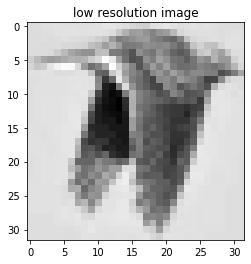

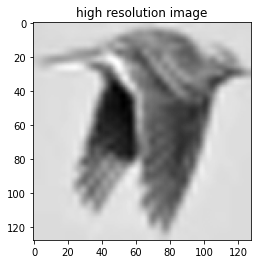

In [4]:
# Load image data
ishape = 128
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

# Reduce the dataset
train_image = train_images[0:10000]
test_image = test_images[0:1000]

x_train = np.array([cv.cvtColor(img, cv.COLOR_BGR2GRAY) for img in train_image])
x_test = np.array([cv.cvtColor(img, cv.COLOR_BGR2GRAY) for img in test_image])

y_train = np.array([cv.cvtColor(cv.resize(img, (ishape, ishape), interpolation=cv.INTER_CUBIC), cv.COLOR_BGR2GRAY) for img in train_image])
y_test = np.array([cv.cvtColor(cv.resize(img, (ishape, ishape), interpolation=cv.INTER_CUBIC), cv.COLOR_BGR2GRAY) for img in test_image])

# Show an example image
example_idx = 123
plt.figure('LR')
plt.imshow(x_train[example_idx], cmap=plt.cm.gray)
plt.title('low resolution image')
plt.figure('HR')
plt.imshow(y_train[example_idx], cmap=plt.cm.gray)
plt.title('high resolution image')
plt.show()

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], y_train.shape[2], 1))
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], y_test.shape[2], 1))

In [5]:
# Train the model
def PSNR(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=255.0)

def SSIM(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=255.0)

model.compile(optimizer=keras.optimizers.Adam(0.0001), loss='mse', metrics=[PSNR, SSIM, 'accuracy'])

history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)

print('Test loss:', test_scores[0])
print('Test mse:', test_scores[1])

# Save entire model to a HDF5 file
model.save('SR-ILLNN.h5')

Epoch 1/10
125/125 [==============================] - 183s 1s/step - loss: 9.2926 - PSNR: 41.0541 - SSIM: 0.9842 - accuracy: 0.0037 - val_loss: 1.2240 - val_PSNR: 47.8244 - val_SSIM: 0.9963 - val_accuracy: 0.0031
Epoch 2/10
125/125 [==============================] - 153s 1s/step - loss: 0.7159 - PSNR: 50.2461 - SSIM: 0.9976 - accuracy: 0.0040 - val_loss: 0.4873 - val_PSNR: 51.7546 - val_SSIM: 0.9982 - val_accuracy: 0.0032
Epoch 3/10
125/125 [==============================] - 153s 1s/step - loss: 0.4439 - PSNR: 52.1491 - SSIM: 0.9983 - accuracy: 0.0040 - val_loss: 0.4375 - val_PSNR: 52.1419 - val_SSIM: 0.9985 - val_accuracy: 0.0031
Epoch 4/10
125/125 [==============================] - 153s 1s/step - loss: 0.3603 - PSNR: 53.0184 - SSIM: 0.9985 - accuracy: 0.0040 - val_loss: 0.3471 - val_PSNR: 53.1225 - val_SSIM: 0.9986 - val_accuracy: 0.0031
Epoch 5/10
125/125 [==============================] - 153s 1s/step - loss: 0.3420 - PSNR: 53.2479 - SSIM: 0.9986 - accuracy: 0.0040 - val_loss: 0.30

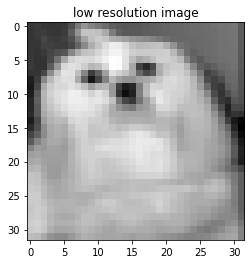

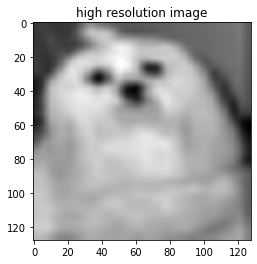

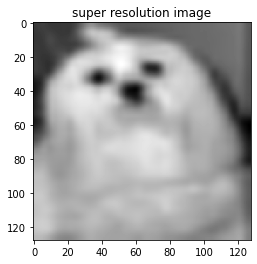

In [6]:
# Set real test image
img = train_images[20001]
lr = np.array(cv.cvtColor(img, cv.COLOR_BGR2GRAY))
hr = np.array(cv.cvtColor(cv.resize(img, (ishape, ishape), interpolation=cv.INTER_CUBIC), cv.COLOR_BGR2GRAY))
test_input = np.reshape(lr, (1, 32, 32, 1))

# Predict a result
sr = model.predict(test_input)
plt.figure('LR')
plt.title('low resolution image')
plt.imshow(lr, cmap=plt.cm.gray)
plt.figure('HR')
plt.title('high resolution image')
plt.imshow(hr, cmap=plt.cm.gray)
plt.figure('SR')
plt.title('super resolution image')
plt.imshow(sr[0][:, :, 0] / 255.0, cmap=plt.cm.gray)
plt.show()